# Simple Rocket Soft-Landing Problem

This notebook is a walkthough of the ALTRO solver for the Rocket Soft-Landing Problem (i.e. the general control challenge of landing a rocket at rest at a designated landing site). In the simplest case, we treat the rocket as a sphere landing on a flat surface with no atmosphere. This approximation is reasonable when the rocket is near the ground and entering the final part of the descent.

## Load Required Packages

The <code>RobotDynamics</code> package enables us to define the rocket model and dynamics. The <code>TrajectoryOptimization</code> and <code>Altro</code> set-up and solve the trajectory optimization problem. <code>StaticArrays</code> and <code>LinearAlgebra</code> are required to set-up the appropriate data types.

Lastly, <code>Plots</code> is used to visualize the results. Note that the plotting sections will take significantly longer to run than the optimization.

In [9]:
using RobotDynamics
import RobotDynamics: dynamics
using TrajectoryOptimization, Altro
using StaticArrays, LinearAlgebra

using Plots
pyplot()

Plots.PyPlotBackend()

## Define and Create the Rocket Model

Unlike the Cartpole and Quadrotor models, the Rocket Model is not in the <code>RobotZoo.jl</code> package. Instead, here we build off of work found in the repository below to develop a simplified rocket soft-landing scenario (i.e. no second-order cone constraints and no attitude dynamics). https://github.com/danineamati/TrajOptSOCPs.jl

First, to prepare the model, we inherit from the <code>AbstractModel</code> type (see http://roboticexplorationlab.org/RobotDynamics.jl/dev/models.html and http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/models.html for more information). In the simplified case, <code>Rocket</code> only holds the mass and the gravity vector. In the full rocket landing problem, the inertia matrix must also be provided. Separately, the thurster's specific impulse can be used to scale the optimal controls.

In [10]:
struct Rocket{T} <: AbstractModel
    mass::T  # mass of the rocket
    g::SArray{Tuple{3},T,1,3}   # gravity
end

# Set-up the default constructor for ease of use
Rocket() = Rocket(10.0, SA[0.0; 0.0; -9.81])

Rocket

## Detail the Rocket Dynamics

For the simplified rocket problem, we choose to ignore the attitude dynamics. Applying newton's second law or by forming a Lagrangian, we arrive at the following sparse system

$$\frac{dx}{dt} = Ax + Bu + g$$

Where $A = \begin{bmatrix}0 & I\\ 0 & 0 \end{bmatrix}$, $B = \begin{bmatrix}0 \\ \frac{1}{m} I\end{bmatrix}$, and $G = \begin{bmatrix} 0 \\ -g \end{bmatrix}$. For the 3D case, these are $(6 \times 6)$, $(6 \times 3)$, and $(6 \times 1)$ matricies, respectively.

Since the system is so sparse, we can reduce unnecessary computations by writing the equations for the first and second derivatives. We use the notation of $q = [x; y; z]$ (the positions) and $\frac{dq}{dt} = [v_x; v_y; v_z]$ (the velocities). 

$$\frac{dq}{dt} = \frac{dq}{dt}$$
$$\frac{d^2q}{dt^2} = \frac{1}{m} u - g$$

In [11]:
"""
    dynamics(model::Rocket, x, u)

For the simple rocket, we have a linear dynamics system.
"""
function dynamics(model::Rocket, x, u)
    m = model.mass   # mass of the rocket in kg (1)
    g = model.g     # gravity m/s^2

    # q  = x[SA[1,2,3]] # [x, y, z, ...]
    qd = x[SA[4,5,6]] # [..., vx, vy, vz]

    nDim = size(u, 1) # i.e. a 3D system -> 3
    B = -(1/m) * I

    qdd = B * u - g
    return [qd; qdd]
end

RobotDynamics.state_dim(::Rocket) = 6
RobotDynamics.control_dim(::Rocket) = 3

## Instantiate the Model and Define the Discretization

Feel free to choose <code>N</code> and <code>tf</code> based on your needs.

In [13]:
model = Rocket()
n, m = size(model)
# n is the size of the states ([x, y, z, vx, vy, vz])
# m is the size of the control thrust ([Tx, Ty, Tz]])

# Trajectory Discretization
N = 251
tf = 10.
dt = tf/(N-1)

model # (Simply for information) Display the struct as the cell output 

Rocket{Float64}(10.0, [0.0, 0.0, -9.81])

## Specify the Initial and Final Conditions

Choose the initial and final points. Note that these must be full state vectors ($[x; y; z; v_x; v_y; v_z]$). The initial point is generally the rocket's current state. The final point is generally the rocket's landing stop. Note that the final velocity of the rocket should **always** be $[0.0; 0.0; 0.0]$ to have a **soft** landing.

In [15]:
# Initial and Final Conditions
x0 = @SVector [1.0, 0.0, 20.0, -0.1, 0.0, -19.0] # Start at a 20 m altitude
xf = @SVector zeros(n);  # Swing pendulum up and end at rest

## Set-Up the LQR Objective Function

For this problem, we choose an LQR Objective Function. One can add waypoints or change the weights to craft different optimal trajectories. See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/costfunctions.html for more information.

In [16]:
Q = 1.0e-2 * Diagonal(@SVector ones(n))
Qf = 100.0 * Diagonal(@SVector ones(n))
R = 1.0e-1 * Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N)

Objective

## Define the Constraints

For the simple rocket soft-landing problem, we will include 4 constraints:
1. Crash Prevention Constraint ($z > 0$)
2. Vertical Thrust Bounds ($0 < u_z < u_{z, \ max}$), which is a simplification of a max thrust constraint
3. Lateral Thurst Bounds ($-u_{lateral, \ max} < u_{x, y} < u_{lateral, \ max}$), which is a simplification of a max thrust angle constraint
4. Landing Site Designation ($x[t_f] = x_f$)

For details on the implemented constraint types, please check out http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/constraints.html.

In [17]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Bounds
ground_level = 0.0 # Crash Prevention Constraint
umax = 11 * model.mass # Simplified Max Thrust Constraint
theta = 20 # deg. Max Angle Constraint
ulateral_max = umax * sind(theta)

# To ignore constraints 2 and 3, use the code below
# bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
#                                   -Inf, -Inf, -Inf])

# To include constraints 2 and 3, use the code below
bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                  -Inf, -Inf, -Inf],
                           u_min=[-ulateral_max, -ulateral_max, 0   ],
                           u_max=[ ulateral_max,  ulateral_max, umax])
add_constraint!(conSet, bnd, 1:N-1)

# Goal Constraint that the rocket must reach the landing site.
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

## Stitch together the objective and constraints

See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/creating_problems.html for more information.

In [19]:
# Package the objective and constraints into a "problem" type
prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet);

## Initialize the Trajectory

We choose to initialize the trajectory at a hover (i.e. the rocket trajectory will initially only counter gravity).

In [20]:
u0 = model.g # controls that would naminally hover
U0 = [u0 for k = 1:N-1] # vector of the small controls
initial_controls!(prob, U0)
rollout!(prob);

## Select the solver options

For more information, please visit https://github.com/RoboticExplorationLab/Altro.jl/blob/master/README.md for more details on the solver options.

Using the Altro package, we can now specify parameters and solve the problem.

In [21]:
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=10.,
    penalty_initial=1.0
)

SolverOptions{Float64}
  constraint_tolerance: Float64 1.0e-6
  cost_tolerance: Float64 0.0001
  cost_tolerance_intermediate: Float64 0.01
  gradient_tolerance: Float64 10.0
  gradient_tolerance_intermediate: Float64 1.0
  iterations_inner: Int64 300
  dJ_counter_limit: Int64 10
  square_root: Bool false
  line_search_lower_bound: Float64 1.0e-8
  line_search_upper_bound: Float64 10.0
  iterations_linesearch: Int64 20
  max_cost_value: Float64 1.0e8
  max_state_value: Float64 1.0e8
  max_control_value: Float64 1.0e8
  static_bp: Bool true
  save_S: Bool false
  bp_reg: Bool false
  bp_reg_initial: Float64 0.0
  bp_reg_increase_factor: Float64 1.6
  bp_reg_max: Float64 1.0e8
  bp_reg_min: Float64 1.0e-8
  bp_reg_type: Symbol control
  bp_reg_fp: Float64 10.0
  penalty_initial: Float64 1.0
  penalty_scaling: Float64 10.0
  active_set_tolerance_al: Float64 0.001
  dual_max: Float64 NaN
  penalty_max: Float64 NaN
  iterations_outer: Int64 30
  kickout_max_penalty: Bool false
  reset_duals:

Show summary is set to <code>true</code> to print the solver speed. In general the solve will take about 23 iterations and 36-60 ms to complete. The constraint violation should be around $10^{-4}$ or better.

In [27]:
altro = ALTROSolver(prob, opts)
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 23
    Solve Time: 58.893499 (ms)

  Covergence
    Terminal Cost: 3723.71148336481
    Terminal dJ: -0.0006012566968820465
    Terminal gradient: 0.01257958240354246
    Terminal constraint violation: 0.0001398119385030273
    Solve Status: SOLVE_SUCCEEDED


## Access the Trajectory

In [29]:
X = states(altro)
U = controls(altro)

xs = [x[1] for x in X]
zs = [x[3] for x in X]

uxs = [u[1] for u in U]
uzs = [u[3] for u in U];

## Plot the trajectory!

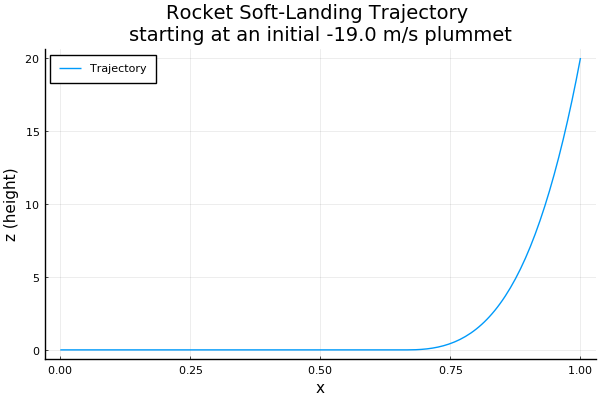

In [31]:
titleText = "Rocket Soft-Landing Trajectory \n" *
        "starting at an initial $(x0[6]) m/s plummet"
filename = "RocketGroundThrustBound_BarelyFeasible3"

plt_x = plot(xs, zs, label = "Trajectory")
xlabel!("x")
ylabel!("z (height)")
title!(titleText)

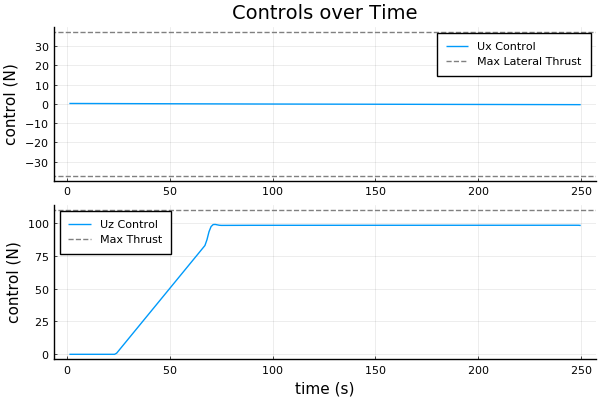

In [32]:
plt_ux = plot(uxs, label = "Ux Control")
hline!([-ulateral_max, ulateral_max], linecolor = :grey, linestyle = :dash,
                label = "Max Lateral Thrust")
# xlabel!("time (s)")
ylabel!("control (N)")
title!("Controls over Time")

plt_uz = plot(uzs, label = "Uz Control")
hline!([umax], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
xlabel!("time (s)")
ylabel!("control (N)")

plt_u = plot(plt_ux, plt_uz, layout = (2, 1))

Below is a GIF of the trajectory. This will take several seconds to generate.

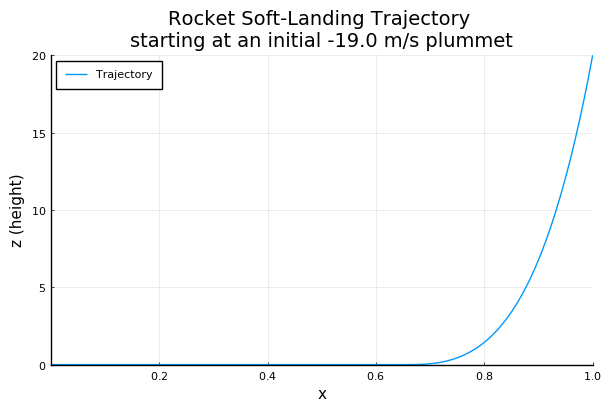

┌ Info: Saved animation to 
│   fn = C:\Users\Daniel N\.julia\dev\TrajectoryOptimization.jl\examples\tmp.gif
└ @ Plots C:\Users\Daniel N\.julia\packages\Plots\M1wcx\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Daniel N\\.julia\\dev\\TrajectoryOptimization.jl\\examples\\tmp.gif")
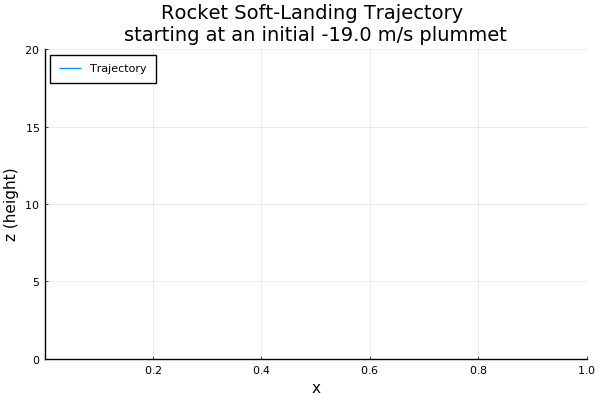

In [34]:
xmin = minimum(xs)
xmax = maximum(xs)

zmin = minimum(zs)
zmax = maximum(zs)

@gif for i in 1:N
    plt = plot(xs[1:i], zs[1:i], label = "Trajectory", legend = :topleft)
    xlabel!("x")
    ylabel!("z (height)")
    xlims!(xmin,xmax)
    ylims!(zmin,zmax)
    title!(titleText)
end